<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Sushant/DLS_Assignment_3_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import librosa
import librosa.display
import timeit
from IPython.display import Audio
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import soundfile as sf
from tensorflow.keras.layers import Conv1D,Conv2D,MaxPooling1D,MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from keras.models import Model
import pickle
import tarfile

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.773524445999982
GPU (s):
0.04212172100000089
GPU speedup over CPU: 137x


In [5]:
cifar10 = keras.datasets.cifar10

In [6]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
x_train_scale = x_train/255
x_test_scale = x_test/255

In [8]:
print("The size of training set is : ",len(x_train))
print("The size of training labels is : ",len(y_train))
print("The size of testing set is : ",len(x_test))
print("The size of testing labels is : ",len(y_test))

The size of training set is :  50000
The size of training labels is :  50000
The size of testing set is :  10000
The size of testing labels is :  10000


## Splitting data into labelled and unlabelled examples

In [9]:
X_train_labelled = x_train_scale[49500:50000]
Y_train_labelled = y_train[49500:50000]

In [10]:
#X_train_labelled = tf.convert_to_tensor(X_train_labelled)
#_train_labelled = tf.convert_to_tensor(Y_train_labelled)

In [11]:
print("The size of labelled training set is : ",len(X_train_labelled))
print("The size of labelled training labels is : ",len(Y_train_labelled))
print("The type of labelled training set is : ",type(X_train_labelled))
print("The type of labelled training labels is : ",type(Y_train_labelled))

The size of labelled training set is :  500
The size of labelled training labels is :  500
The type of labelled training set is :  <class 'numpy.ndarray'>
The type of labelled training labels is :  <class 'numpy.ndarray'>


In [12]:
X_train_unlabelled = x_train_scale[0:49500]
Y_train_unlabelled = y_train[0:49500]

In [13]:
#X_train_unlabelled = tf.convert_to_tensor(X_train_unlabelled)
#Y_train_unlabelled = tf.convert_to_tensor(Y_train_unlabelled)

In [14]:
print("The size of unlabelled training set is : ",len(X_train_unlabelled))
print("The size of unlabelled training labels is : ",len(Y_train_unlabelled))
print("The type of unlabelled training set is : ",type(X_train_unlabelled))
print("The type of unlabelled training labels is : ",type(Y_train_unlabelled))

The size of unlabelled training set is :  49500
The size of unlabelled training labels is :  49500
The type of unlabelled training set is :  <class 'numpy.ndarray'>
The type of unlabelled training labels is :  <class 'numpy.ndarray'>


In [15]:
Y_train_unlabelled.shape

(49500, 1)

## Creating Dummy Labels

In [16]:
class_0_training = tf.convert_to_tensor(X_train_unlabelled)
class_0_labels = tf.zeros(shape=[49500, 1], dtype=tf.int32)
#class_0_training_scale2 = class_0_training - np.mean(class_0_training)

In [17]:
class_1_training = tf.image.flip_up_down(X_train_unlabelled)
class_1_labels = tf.ones(shape=[49500, 1], dtype=tf.int32)
#class_1_training_scale2 = class_0_training - np.mean(class_0_training)

In [18]:
class_2_training = tf.image.rot90(X_train_unlabelled)
class_2_labels = 2*tf.ones(shape=[49500, 1], dtype=tf.int32)
#class_2_training_scale2 = class_2_training - np.mean(class_2_training)

### Concatenating Dataset

In [19]:
Aug_X_train = tf.concat([class_0_training,class_1_training,class_2_training],0)
Y_train_aug = tf.concat([class_0_labels,class_1_labels,class_2_labels],0)

In [20]:
Aug_X_train = Aug_X_train.numpy()
Aug_X_train = Aug_X_train - Aug_X_train.mean()
Aug_X_train = tf.convert_to_tensor(Aug_X_train)

In [21]:
#x_test_scale2 = x_test_scale.numpy()
x_test_scale2 = x_test_scale - x_test_scale.mean()
#x_test_scale2 = tf.convert_to_tensor(x_test_scale2)

In [22]:
#X_train_labelled_scale2 = X_train_labelled.numpy()
X_train_labelled_scale2 = X_train_labelled - X_train_labelled.mean()
#X_train_labelled_scale2 = tf.convert_to_tensor(X_train_labelled_scale2)

In [23]:
#Aug_X_train_scale2 = Aug_X_train - np.mean(Aug_X_train)

In [24]:
#x_test_scale2 = rescale(x_test_scale)

In [25]:
#X_train_labelled_scale2 = rescale(X_train_labelled)

In [26]:
print("The size of augmented training set is : ",len(Aug_X_train))
print("The size of augmented training labels is : ",len(Y_train_aug))

The size of augmented training set is :  148500
The size of augmented training labels is :  148500


## Pretext Model

In [27]:
kaiming_he = keras.initializers.HeNormal()

In [28]:
model_1 = keras.Sequential([
              layers.Conv2D(filters=10, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_initializer=kaiming_he, data_format = 'channels_last', input_shape=(32,32,3)),
              layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
              layers.Conv2D(filters=10, kernel_size=(5,5), strides=(1,1), activation='relu',kernel_initializer=kaiming_he, data_format = 'channels_last'),
              layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
              layers.Flatten(),
              layers.Dense(units=20, activation="relu", kernel_initializer=kaiming_he),
              layers.Dense(units=3, activation="softmax", kernel_initializer=kaiming_he)
])

In [29]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["acc"])

In [30]:
history_1 = model_1.fit(Aug_X_train, Y_train_aug, epochs=100, batch_size=128)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1161/1161 [==============================] - 11s 6ms/step - loss: 0.8449 - acc: 0.6024
Epoch 2/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.7471 - acc: 0.6666
Epoch 3/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.7138 - acc: 0.6825
Epoch 4/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.6917 - acc: 0.6947
Epoch 5/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.6752 - acc: 0.7028
Epoch 6/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.6630 - acc: 0.7099
Epoch 7/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.6525 - acc: 0.7150
Epoch 8/100
1161/1161 [==============================] - 7s 6ms/step - loss: 0.6433 - acc: 0.7190
Epoch 9/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.6374 - acc: 0.7225
Epoch 10/100
1161/1161 [==============================] - 6s 5ms/step - loss: 0.6312 - acc: 0.7251
Epoch 11/100
1161/1161 [======

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [65]:
path = '/content/gdrive/MyDrive/DLS_Assignments/Models/assign3_part2_model_1.h5'
model_1.save(path)

## Baseline Model

In [33]:
he_init = keras.initializers.HeNormal()

In [34]:
baseline_model = keras.Sequential([
              layers.Conv2D(filters=10, kernel_size=(5,5), strides=(1,1), activation='relu', kernel_initializer=he_init, data_format = 'channels_last', input_shape=(32,32,3)),
              layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
              layers.Conv2D(filters=10, kernel_size=(5,5), strides=(1,1), activation='relu',kernel_initializer=he_init, data_format = 'channels_last'),
              layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
              layers.Flatten(),
              layers.Dense(units=20, activation="relu", kernel_initializer=he_init),
              layers.Dense(units=10, activation="softmax", kernel_initializer=he_init)
])

In [35]:
baseline_model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["acc"])

In [36]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 20)               

In [37]:
history_2 = baseline_model.fit(X_train_labelled_scale2, Y_train_labelled, epochs=10000, validation_data=[x_test_scale2,y_test],batch_size=256)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 192ms/step - loss: 7.9870e-08 - acc: 1.0000 - val_loss: 16.7165 - val_acc: 0.2907
Epoch 7502/10000
2/2 [==============================] - 0s 192ms/step - loss: 8.0824e-08 - acc: 1.0000 - val_loss: 16.7172 - val_acc: 0.2907
Epoch 7503/10000
2/2 [==============================] - 0s 337ms/step - loss: 8.2016e-08 - acc: 1.0000 - val_loss: 16.7176 - val_acc: 0.2907
Epoch 7504/10000
2/2 [==============================] - 0s 181ms/step - loss: 8.0824e-08 - acc: 1.0000 - val_loss: 16.7186 - val_acc: 0.2907
Epoch 7505/10000
2/2 [==============================] - 0s 337ms/step - loss: 7.9393e-08 - acc: 1.0000 - val_loss: 16.7198 - val_acc: 0.2906
Epoch 7506/10000
2/2 [==============================] - 0s 338ms/step - loss: 7.9632e-08 - acc: 1.0000 - val_loss: 16.7205 - val_acc: 0.2906
Epoch 7507/10000
2/2 [==============================] - 0s 344ms/step - loss: 7.9632e-08 - acc: 1.0000 - val_loss: 16.72

### Baseline Model Graph

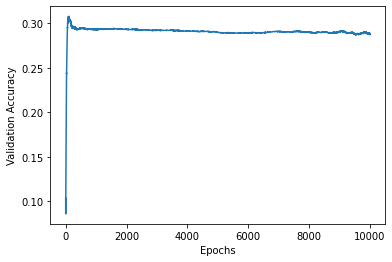

In [81]:
plt.plot(range(1,10001),history_2.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

In [66]:
path_2= '/content/gdrive/MyDrive/DLS_Assignments/Models/assign3_part2_baseline_model.h5'
baseline_model.save(path_2)

## Transfer Learning Model

In [67]:
transfer_learning_model = keras.models.load_model('/content/gdrive/MyDrive/DLS_Assignments/Models/assign3_part2_model_1.h5')

In [68]:
transfer_learning_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 20)                5

In [69]:
transfer_learning_model.pop()

In [70]:
transfer_learning_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 28, 28, 10)        760       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 10)       0         
 )                                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 10, 10, 10)        2510      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 10)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 20)                5

In [71]:
transfer_learning_model.add(layers.Dense(units=10,activation='softmax',kernel_initializer=he_init))

In [72]:
optimizers = [tf.keras.optimizers.Adam(learning_rate=1e-6),
              tf.keras.optimizers.Adam(learning_rate=1e-3)]

In [73]:
custom_optimizer = [(optimizers[0], transfer_learning_model.layers[:-1]), (optimizers[1], transfer_learning_model.layers[-1])]

In [74]:
optimizer = tfa.optimizers.MultiOptimizer(custom_optimizer)
transfer_learning_model.compile(optimizer=optimizer,
                loss="sparse_categorical_crossentropy",
                metrics=['acc'])

In [75]:
history_3 = transfer_learning_model.fit(X_train_labelled_scale2,Y_train_labelled,epochs=10000,validation_data=(x_test_scale2,y_test),batch_size=512)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 179ms/step - loss: 1.3040 - acc: 0.4940 - val_loss: 2.1601 - val_acc: 0.3340
Epoch 7502/10000
1/1 [==============================] - 0s 158ms/step - loss: 1.3040 - acc: 0.4940 - val_loss: 2.1602 - val_acc: 0.3340
Epoch 7503/10000
1/1 [==============================] - 0s 168ms/step - loss: 1.3040 - acc: 0.4960 - val_loss: 2.1603 - val_acc: 0.3340
Epoch 7504/10000
1/1 [==============================] - 0s 174ms/step - loss: 1.3039 - acc: 0.4960 - val_loss: 2.1604 - val_acc: 0.3340
Epoch 7505/10000
1/1 [==============================] - 0s 185ms/step - loss: 1.3039 - acc: 0.4960 - val_loss: 2.1605 - val_acc: 0.3341
Epoch 7506/10000
1/1 [==============================] - 0s 165ms/step - loss: 1.3038 - acc: 0.4960 - val_loss: 2.1606 - val_acc: 0.3341
Epoch 7507/10000
1/1 [==============================] - 0s 194ms/step - loss: 1.3038 - acc: 0.4960 - val_loss: 2.1607 - val_acc: 0.3340
Epoch 7508/100

In [76]:
path_3= '/content/gdrive/MyDrive/DLS_Assignments/Models/assign3_part2_transfer_learning.h5'
transfer_learning_model.save(path_3)

### Comparing Baseline Models and Transfer Learning Models

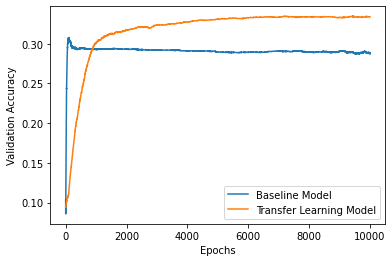

In [79]:
plt.plot(range(1,10001),history_2.history['val_acc'],label='Baseline Model')
plt.plot(range(1,10001),history_3.history['val_acc'],label='Transfer Learning Model')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.show()